In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

Data Loaded. Shape: (11063, 29)


In [146]:
# Set visual style
sns.set_style("whitegrid")

df = pd.read_csv('../dataset/15_9-23.csv') 


print(f"Data Loaded. Shape: {df.shape}")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11063 entries, 0 to 11062
Data columns (total 29 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   WELL                               11063 non-null  object 
 1   DEPTH_MD                           11063 non-null  float64
 2   X_LOC                              11063 non-null  float64
 3   Y_LOC                              11063 non-null  float64
 4   Z_LOC                              11063 non-null  float64
 5   GROUP                              11063 non-null  object 
 6   FORMATION                          11063 non-null  object 
 7   CALI                               11063 non-null  float64
 8   RSHA                               0 non-null      float64
 9   RMED                               11009 non-null  float64
 10  RDEP                               11063 non-null  float64
 11  RHOB                               11009 non-null  flo

In [147]:
df=df.drop(['RSHA','SP','SGR','MUDWEIGHT','RMIC','RXO'],axis=1)

In [148]:
df=df.dropna()

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10302 entries, 54 to 10940
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   WELL                               10302 non-null  object 
 1   DEPTH_MD                           10302 non-null  float64
 2   X_LOC                              10302 non-null  float64
 3   Y_LOC                              10302 non-null  float64
 4   Z_LOC                              10302 non-null  float64
 5   GROUP                              10302 non-null  object 
 6   FORMATION                          10302 non-null  object 
 7   CALI                               10302 non-null  float64
 8   RMED                               10302 non-null  float64
 9   RDEP                               10302 non-null  float64
 10  RHOB                               10302 non-null  float64
 11  GR                                 10302 non-null  float64

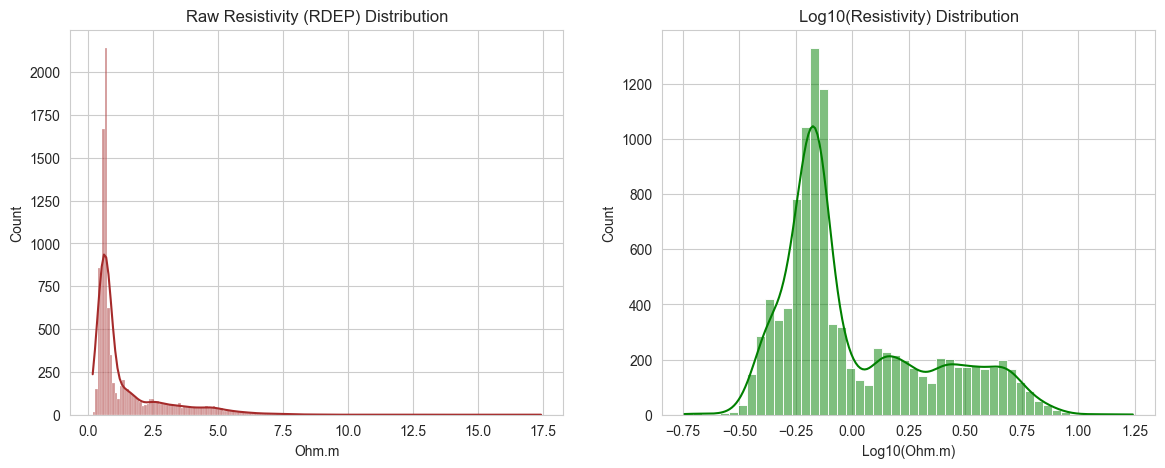

In [150]:
plt.figure(figsize=(14, 5))

# Plot 1: Raw Distribution
plt.subplot(1, 2, 1)
sns.histplot(df['RDEP'].dropna(), kde=True, color='brown')
plt.title("Raw Resistivity (RDEP) Distribution")
plt.xlabel("Ohm.m")

# Plot 2: Log10 Distribution
plt.subplot(1, 2, 2)
# We use log10 (handling potential zeros slightly)
log_rdep = np.log10(df['RDEP'].dropna())
sns.histplot(log_rdep, kde=True, color='green')
plt.title("Log10(Resistivity) Distribution")
plt.xlabel("Log10(Ohm.m)")

plt.show()

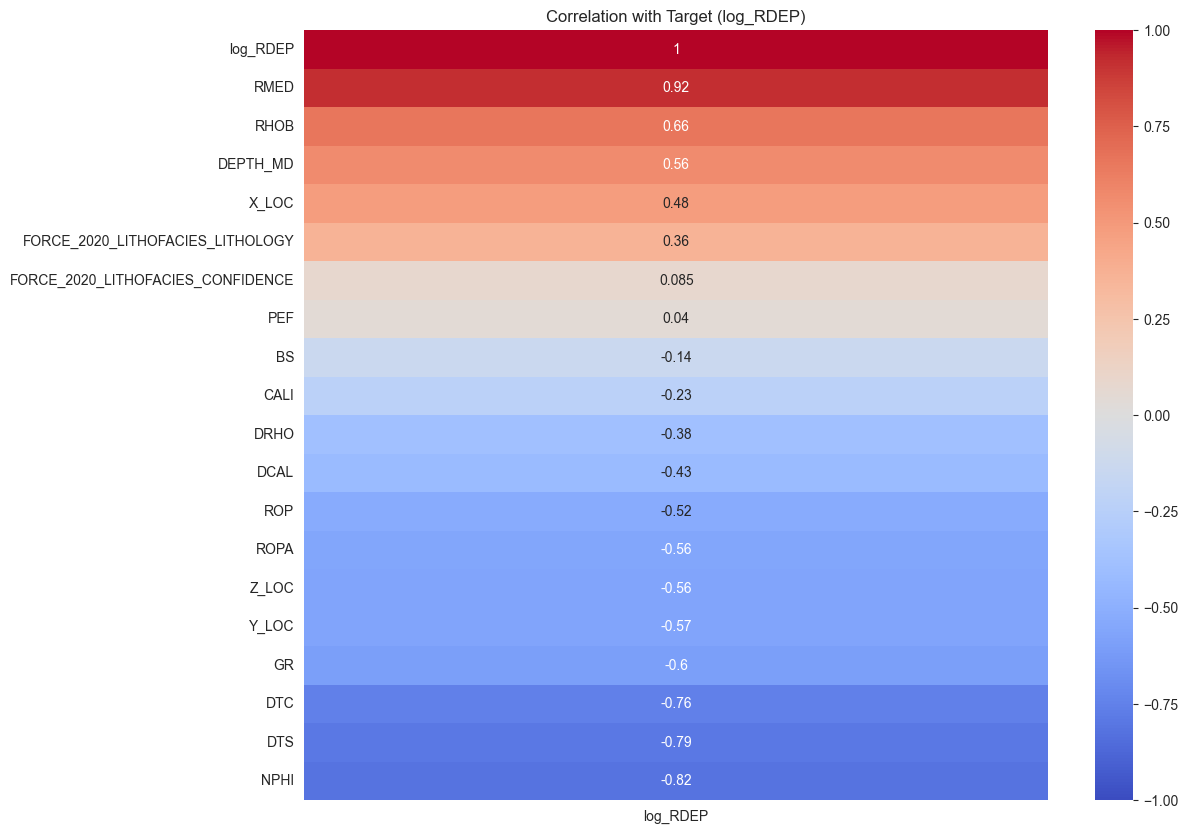

In [151]:
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number]).copy()

# Apply Log to RDEP for the correlation check (since we will model the log)
numeric_df['log_RDEP'] = np.log10(numeric_df['RDEP'])
# Drop the raw RDEP so it doesn't correlate with itself
numeric_df = numeric_df.drop(columns=['RDEP'])

# Calculate Matrix
corr_matrix = numeric_df.corr()

# Visualize
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix[['log_RDEP']].sort_values(by='log_RDEP', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation with Target (log_RDEP)")
plt.show()

In [152]:
# 1. Define Target
target = 'log_RDEP'

# 2. Automated Selection: Pick features with correlation > 0.3 (or < -0.3)
# This removes noise like 'X_LOC' or 'Bit Size' automatically
correlations = corr_matrix[target]
features = correlations[abs(correlations) > 0.59].index.drop(target).tolist()

print(f"Selected Predictors based on EDA: {features}")

# 3. Prepare the Clean Dataset (Ground Truth)
# We need rows where ALL selected features + target are present
df_clean = df.copy()
df_clean['log_RDEP'] = np.log10(df_clean['RDEP']) # Create the target
df_clean = df_clean[features + [target]].dropna()


print(f"Final Dataset Size for PoC: {len(df_clean)}")

df_clean=df_clean.drop('RMED',axis=1)
df_clean.info()

✅ Selected Predictors based on EDA: ['RMED', 'RHOB', 'GR', 'NPHI', 'DTC', 'DTS']
Final Dataset Size for PoC: 10302
<class 'pandas.core.frame.DataFrame'>
Index: 10302 entries, 54 to 10940
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   RHOB      10302 non-null  float64
 1   GR        10302 non-null  float64
 2   NPHI      10302 non-null  float64
 3   DTC       10302 non-null  float64
 4   DTS       10302 non-null  float64
 5   log_RDEP  10302 non-null  float64
dtypes: float64(6)
memory usage: 563.4 KB


In [157]:
features.remove('RMED')
print(features)

['RHOB', 'GR', 'NPHI', 'DTC', 'DTS']


In [153]:
# Function to create missing values 
def create_missing_data(dataframe, target_col, frac=0.2, random_state=42):
    """
    Randomly removes 'frac' percentage of data from the target_col.
    Returns:
        df_missing: DataFrame with NaNs
        missing_idx: Indices of the missing rows (to verify later)
        true_values: The original values that were removed
    """
    df_missing = dataframe.copy()
    
    # Get a sample of indices to drop
    np.random.seed(random_state)
    n_samples = int(len(dataframe) * frac)
    missing_idx = np.random.choice(dataframe.index, n_samples, replace=False)
    
    # Store the true values before we delete them (for evaluation)
    true_values = dataframe.loc[missing_idx, target_col].values
    
    # Introduce NaN
    df_missing.loc[missing_idx, target_col] = np.nan
    
    print(f"Removed {n_samples} values from '{target_col}' ({frac*100}%).")
    return df_missing, missing_idx, true_values

In [154]:
# Run the simulation
df_miss, missing_indices, y_true = create_missing_data(df_clean,'log_RDEP', frac=0.2)

Removed 2060 values from 'log_RDEP' (20.0%).


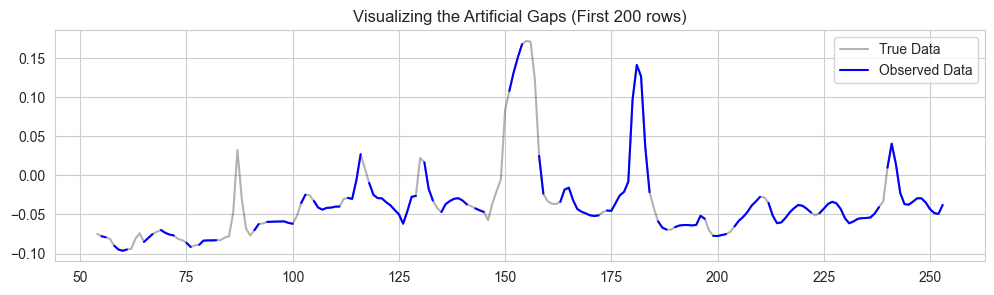

In [155]:
# --- 3. VISUALIZE THE GAP ---
plt.figure(figsize=(12, 3))
plt.plot(df_clean.index[0:200], df_clean['log_RDEP'][0:200], 'k-', label='True Data', alpha=0.3)
plt.plot(df_miss.index[0:200], df_miss['log_RDEP'][0:200], 'b-', label='Observed Data')
plt.title("Visualizing the Artificial Gaps (First 200 rows)")
plt.legend()
plt.show()

In [162]:
# A. Split into Train (Existing Data) and Test (Missing Data)
train_df = df_miss[df_miss[target].notna()]
test_df = df_miss[df_miss[target].isna()]

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]

print("Training Model...")
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test) # This fills the missing values

y_pred_train = model.predict(X_train) 

residuals = y_train - y_pred_train
sigma_naive = np.std(residuals)
print(f"sigma is {sigma_naive:.4f}")

Training Model...
sigma is 0.0258


In [163]:
# Simulation Settings
n_simulations = 100
mc_predictions = []

print("Running Monte Carlo Simulation...")
for pred in y_pred:
    # Generate 100 outcomes per missing point
    sims = np.random.normal(loc=pred, scale=sigma_naive , size=n_simulations)
    mc_predictions.append(sims)

mc_predictions = np.array(mc_predictions) # Shape: (N_missing, 100)

# Calculate Bounds (5th and 95th percentiles)
lower_bound = np.percentile(mc_predictions, 5, axis=1)
upper_bound = np.percentile(mc_predictions, 95, axis=1)
mc_mean = np.mean(mc_predictions, axis=1)

Running Monte Carlo Simulation...


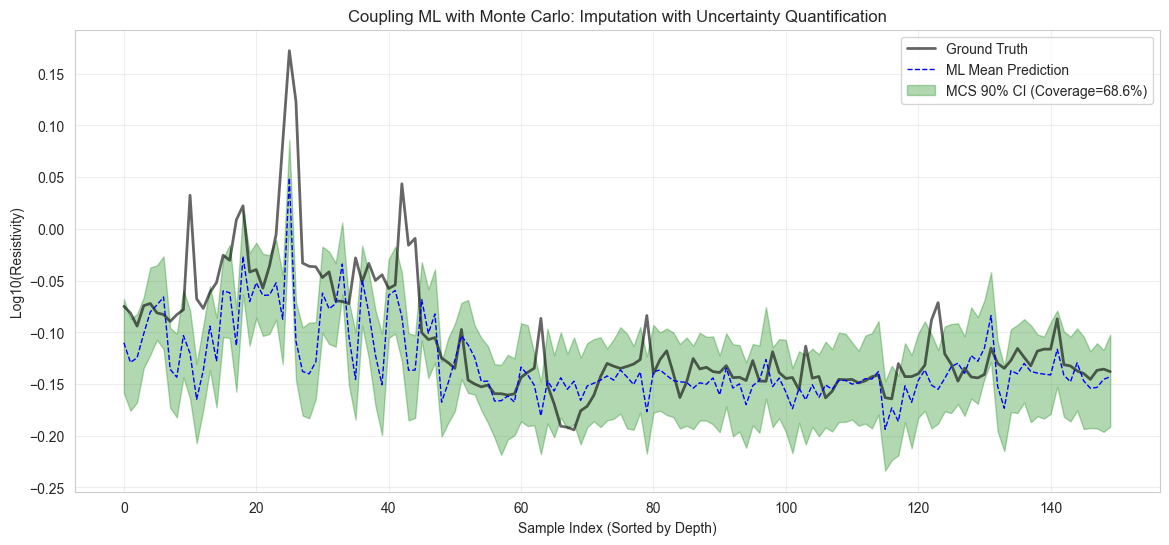

In [164]:
# --- CRITICAL FIX: ALIGN GROUND TRUTH ---
# We must fetch the true values using the SAME INDICES as the test set
# ensuring that y_true matches y_pred row-for-row.
y_true_aligned = df_clean.loc[test_df.index, target].values

# --- RE-CALCULATE METRICS WITH ALIGNED DATA ---
inside_band = (y_true_aligned >= lower_bound) & (y_true_aligned <= upper_bound)
coverage_score = np.mean(inside_band)

# --- PLOTTING ---
# Plotting a subset (zoom in) to see details
zoom_start, zoom_end = 0, 150
indices = range(zoom_end - zoom_start) # Create X-axis indices

plt.figure(figsize=(14, 6))

# 1. Plot Truth (ALIGNED)
plt.plot(indices, y_true_aligned[zoom_start:zoom_end], 
         'k', label='Ground Truth', alpha=0.6, linewidth=2)

# 2. Plot Simple ML Prediction
plt.plot(indices, y_pred[zoom_start:zoom_end], 
         'b--', label='ML Mean Prediction', linewidth=1)

# 3. Plot Monte Carlo Uncertainty Band
plt.fill_between(indices, 
                 lower_bound[zoom_start:zoom_end], 
                 upper_bound[zoom_start:zoom_end], 
                 color='green', alpha=0.3, 
                 label=f'MCS 90% CI (Coverage={coverage_score:.1%})')

plt.title("Coupling ML with Monte Carlo: Imputation with Uncertainty Quantification")
plt.ylabel("Log10(Resistivity)")
plt.xlabel("Sample Index (Sorted by Depth)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [165]:
rfg_rmse=np.sqrt(mean_squared_error(y_true_aligned,y_pred))
print(rfg_rmse)

0.06758433290962827


In [166]:
from sklearn.impute import KNNImputer

# 1. Prepare data for KNN Imputation
# We use all features + the target column
cols_for_imputation = features + [target]
df_knn = df_miss[cols_for_imputation].copy()

# 2. Initialize and Apply KNN Imputer
# KNN will impute all NaNs in the columns provided
imputer = KNNImputer(n_neighbors=5) 
df_imputed_knn = pd.DataFrame(imputer.fit_transform(df_knn), 
                             columns=cols_for_imputation,
                             index=df_knn.index)

# 3. Extract the KNN Predictions for the missing rows
# We use the index alignment trick to get only the predicted values
knn_pred_missing = df_imputed_knn.loc[test_df.index, target].values

# 4. Calculate RMSE for KNN
rmse_knn = np.sqrt(mean_squared_error(y_true_aligned, knn_pred_missing))

print(f"RMSE (KNN Imputer): {rmse_knn:.4f}")

RMSE (KNN Imputer): 0.1067


the improvement is 79.83%


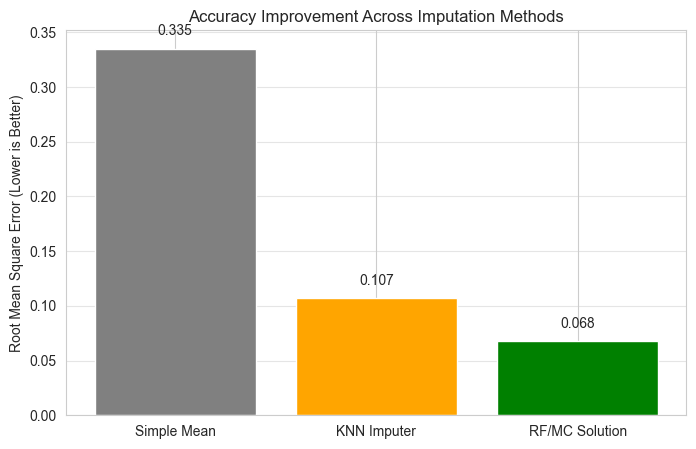

In [168]:
# 1. METHOD A: Simple Imputation (The "Lazy" Way)

# Fill with the global mean of the training data

simple_fill = np.mean(y_train)

# Create an array of this constant value

y_simple_pred = np.full(shape=y_true_aligned.shape, fill_value=simple_fill)

rmse_simple = np.sqrt(mean_squared_error(y_true_aligned, y_simple_pred))

#rmse RF+MC
rmse_mc = np.sqrt(mean_squared_error(y_true_aligned, y_pred))

# 3. Calculate Improvement

improvement = (1 - (rmse_mc / rmse_simple)) * 100
print(f"the improvement is {improvement:.2f}%")


models = ['Simple Mean', 'KNN Imputer', 'RF/MC Solution']
rmses = [rmse_simple, rmse_knn, rmse_mc]
colors = ['gray', 'orange', 'green']

plt.figure(figsize=(8, 5))
bars = plt.bar(models, rmses, color=colors)

# Add the RMSE value on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom', fontsize=10)

plt.ylabel('Root Mean Square Error (Lower is Better)')
plt.title('Accuracy Improvement Across Imputation Methods')
plt.grid(axis='y', alpha=0.5)
plt.show()

In [171]:
print(len(y_true_aligned))

2060


In [172]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10302 entries, 54 to 10940
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   RHOB      10302 non-null  float64
 1   GR        10302 non-null  float64
 2   NPHI      10302 non-null  float64
 3   DTC       10302 non-null  float64
 4   DTS       10302 non-null  float64
 5   log_RDEP  10302 non-null  float64
dtypes: float64(6)
memory usage: 821.4 KB


Removed 2060 values from 'log_RDEP' (20.0%).
Training HistGradientBoostingRegressor...
Gradient Boosting Sigma: 0.0556
--- RESULTS: GRADIENT BOOSTING ---
RMSE: 0.0713 (Improvement: 78.71%)
Coverage: 86.6%


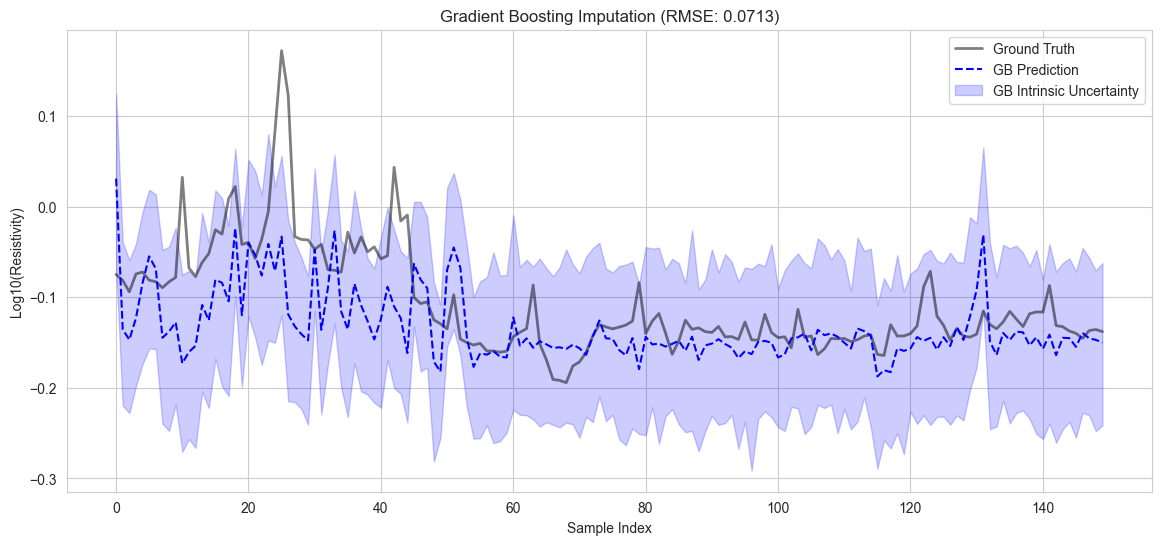

In [173]:
df_miss, missing_idx, y_true_raw = create_missing_data(df_clean, target, frac=0.2)

# --- 2. TRAIN GRADIENT BOOSTING ---
train_df = df_miss[df_miss[target].notna()]
test_df = df_miss[df_miss[target].isna()]

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]

print("Training HistGradientBoostingRegressor...")
# We use HistGradientBoosting - it's faster and often more accurate than standard GBR
model_gb = HistGradientBoostingRegressor(random_state=42)
model_gb.fit(X_train, y_train)

# Predict Mean (Best Guess)
y_pred_gb = model_gb.predict(X_test)

# --- 3. CALCULATE INTRINSIC SIGMA (Tight Bands) ---
# We calculate the model's internal error on the training data
y_train_pred_gb = model_gb.predict(X_train)
residuals_gb = y_train - y_train_pred_gb
sigma_gb = np.std(residuals_gb)

print(f"Gradient Boosting Sigma: {sigma_gb:.4f}")

# --- 4. MONTE CARLO SIMULATION ---
n_simulations = 100
mc_predictions_gb = []

for pred in y_pred_gb:
    sims = np.random.normal(loc=pred, scale=sigma_gb, size=n_simulations)
    mc_predictions_gb.append(sims)

mc_predictions_gb = np.array(mc_predictions_gb)

# Calculate Bounds
lower_gb = np.percentile(mc_predictions_gb, 5, axis=1)
upper_gb = np.percentile(mc_predictions_gb, 95, axis=1)


y_true_aligned = df_clean.loc[test_df.index, target].values

# RMSE
rmse_gb = np.sqrt(mean_squared_error(y_true_aligned, y_pred_gb))
rmse_simple = np.sqrt(mean_squared_error(y_true_aligned, np.full(y_true_aligned.shape, np.mean(y_train))))
improvement = (1 - (rmse_gb / rmse_simple)) * 100

# Coverage
inside_gb = (y_true_aligned >= lower_gb) & (y_true_aligned <= upper_gb)

print(f"--- RESULTS: GRADIENT BOOSTING ---")
print(f"RMSE: {rmse_gb:.4f} (Improvement: {improvement:.2f}%)")
print(f"Coverage: {np.mean(inside_gb):.1%}")

# --- 6. PLOT ---
plt.figure(figsize=(14, 6))
zoom = 150
indices = range(zoom)

plt.plot(indices, y_true_aligned[:zoom], 'k', label='Ground Truth', alpha=0.5, linewidth=2)
plt.plot(indices, y_pred_gb[:zoom], 'b--', label='GB Prediction', linewidth=1.5)
plt.fill_between(indices, lower_gb[:zoom], upper_gb[:zoom], color='blue', alpha=0.2, label='GB Intrinsic Uncertainty')

plt.title(f"Gradient Boosting Imputation (RMSE: {rmse_gb:.4f})")
plt.xlabel("Sample Index")
plt.ylabel("Log10(Resistivity)")
plt.legend()
plt.show()

Removed 2060 values from 'log_RDEP' (20.0%).
Training Neural Network (MLP)...
Neural Network Sigma: 0.0725
--- RESULTS: NEURAL NETWORK ---
RMSE: 0.0756 (Improvement: 77.45%)
Coverage: 90.9%


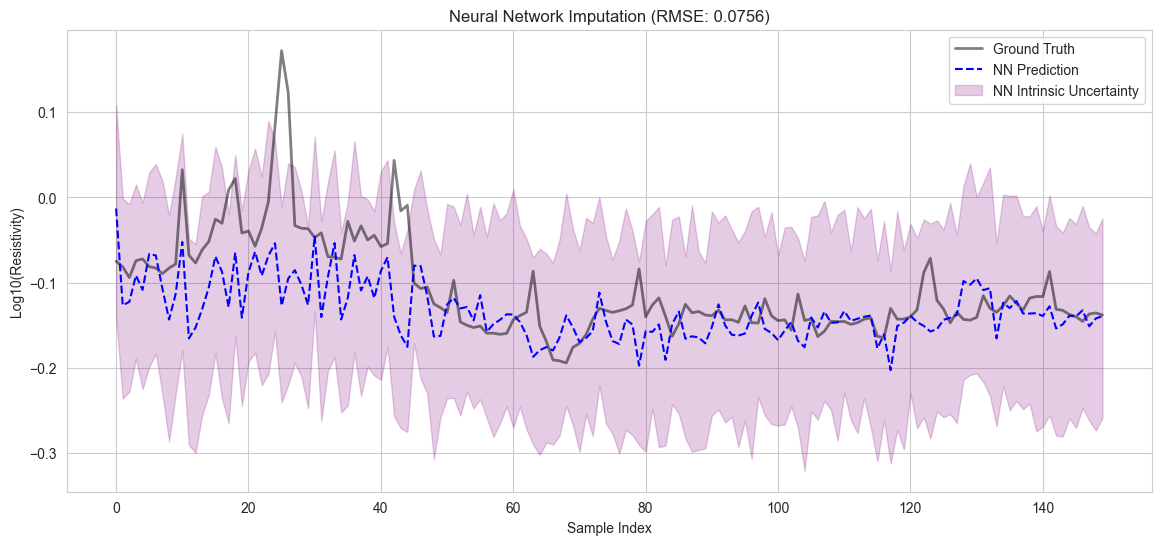

In [188]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# --- 1. SETUP & DATA PREP ---
features = ['RHOB', 'GR', 'NPHI', 'DTS','DTC']
target = 'log_RDEP'

# Re-Sync Data
df_clean = df[features + ['RDEP']].dropna().copy()
df_clean['log_RDEP'] = np.log10(df_clean['RDEP'])
df_miss, missing_idx, y_true_raw = create_missing_data(df_clean, target, frac=0.2)

# Split
train_df = df_miss[df_miss[target].notna()]
test_df = df_miss[df_miss[target].isna()]

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]

# --- 2. DEFINE & TRAIN NEURAL NETWORK ---
print("Training Neural Network (MLP)...")

# We create a Pipeline: Scale Data -> Train Neural Net
# Hidden Layers: (100, 50) means two layers with 100 and 50 neurons
model_nn = make_pipeline(
    StandardScaler(),
    MLPRegressor(hidden_layer_sizes=(100, 50), 
                 activation='relu', 
                 solver='adam', 
                 max_iter=1000, 
                 random_state=42)
)

model_nn.fit(X_train, y_train)

# Predict
y_pred_nn = model_nn.predict(X_test)

# --- 3. CALCULATE SIGMA ---
# Predict on Training Data to get Intrinsic Error
y_train_pred_nn = model_nn.predict(X_train)
residuals_nn = y_train - y_train_pred_nn
sigma_nn = np.std(residuals_nn)

print(f"Neural Network Sigma: {sigma_nn:.4f}")

# --- 4. MONTE CARLO ---
n_simulations = 100
mc_predictions_nn = []

for pred in y_pred_nn:
    sims = np.random.normal(loc=pred, scale=sigma_nn, size=n_simulations)
    mc_predictions_nn.append(sims)

mc_predictions_nn = np.array(mc_predictions_nn)
lower_nn = np.percentile(mc_predictions_nn, 5, axis=1)
upper_nn = np.percentile(mc_predictions_nn, 95, axis=1)

# --- 5. EVALUATION (ALIGNED) ---
y_true_aligned = df_clean.loc[test_df.index, target].values

# RMSE
rmse_nn = np.sqrt(mean_squared_error(y_true_aligned, y_pred_nn))
rmse_simple = np.sqrt(mean_squared_error(y_true_aligned, np.full(y_true_aligned.shape, np.mean(y_train))))
improvement = (1 - (rmse_nn / rmse_simple)) * 100

# Coverage
inside_nn = (y_true_aligned >= lower_nn) & (y_true_aligned <= upper_nn)

print(f"--- RESULTS: NEURAL NETWORK ---")
print(f"RMSE: {rmse_nn:.4f} (Improvement: {improvement:.2f}%)")
print(f"Coverage: {np.mean(inside_nn):.1%}")

# --- 6. PLOT ---
plt.figure(figsize=(14, 6))
zoom = 150
indices = range(zoom)

plt.plot(indices, y_true_aligned[:zoom], 'k', label='Ground Truth', alpha=0.5, linewidth=2)
plt.plot(indices, y_pred_nn[:zoom], 'b--', label='NN Prediction', linewidth=1.5)
plt.fill_between(indices, lower_nn[:zoom], upper_nn[:zoom], color='purple', alpha=0.2, label='NN Intrinsic Uncertainty')

plt.title(f"Neural Network Imputation (RMSE: {rmse_nn:.4f})")
plt.xlabel("Sample Index")
plt.ylabel("Log10(Resistivity)")
plt.legend()
plt.show()

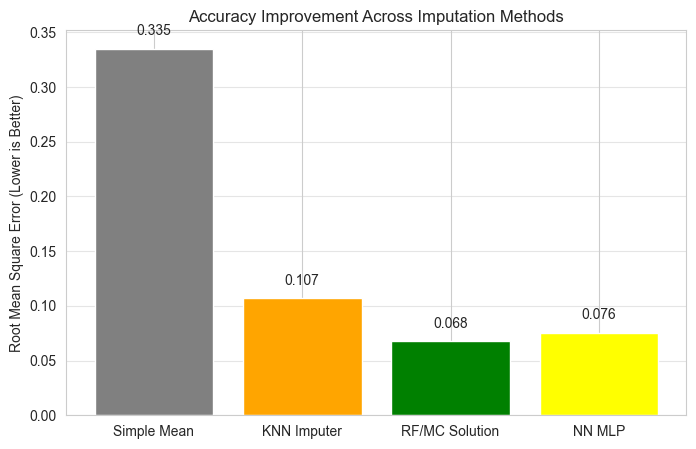

In [189]:
models = ['Simple Mean', 'KNN Imputer', 'RF/MC Solution','NN MLP']
rmses = [rmse_simple, rmse_knn, rmse_mc,rmse_nn]
colors = ['gray', 'orange', 'green','yellow']

plt.figure(figsize=(8, 5))
bars = plt.bar(models, rmses, color=colors)

# Add the RMSE value on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom', fontsize=10)

plt.ylabel('Root Mean Square Error (Lower is Better)')
plt.title('Accuracy Improvement Across Imputation Methods')
plt.grid(axis='y', alpha=0.5)
plt.show()

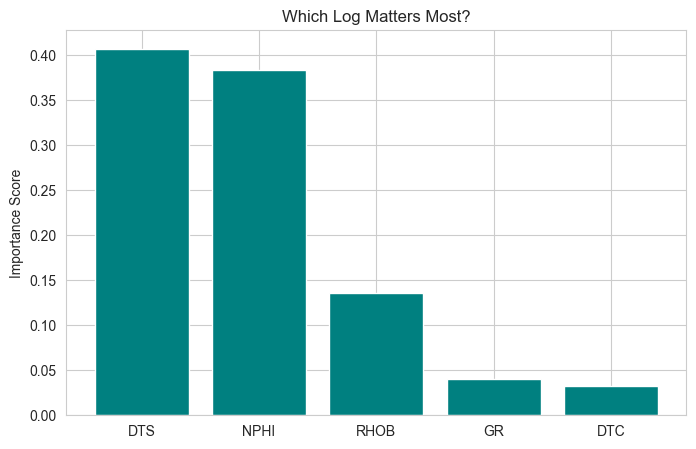

In [190]:


# Get Feature Importances from the trained model

if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    feature_names = features
    
    # Create DataFrame
    feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.bar(feat_imp['Feature'], feat_imp['Importance'], color='teal')
    plt.title("Which Log Matters Most?")
    plt.ylabel("Importance Score")
    plt.show()
    
else:
    print("Using Permutation Importance (better for accurate results)...")
    from sklearn.inspection import permutation_importance
    
    # Calculate importance on the Test set
    result = permutation_importance(model, X_test, y_true_aligned, n_repeats=10, random_state=42)
    
    sorted_idx = result.importances_mean.argsort()
    
    plt.figure(figsize=(8, 5))
    plt.barh(np.array(features)[sorted_idx], result.importances_mean[sorted_idx], color='teal')
    plt.title("Permutation Feature Importance")
    plt.xlabel("Decrease in Accuracy if Feature is Removed")
    plt.show()

Model expects: ['RHOB' 'GR' 'NPHI' 'DTC' 'DTS']
Calculating Importance...


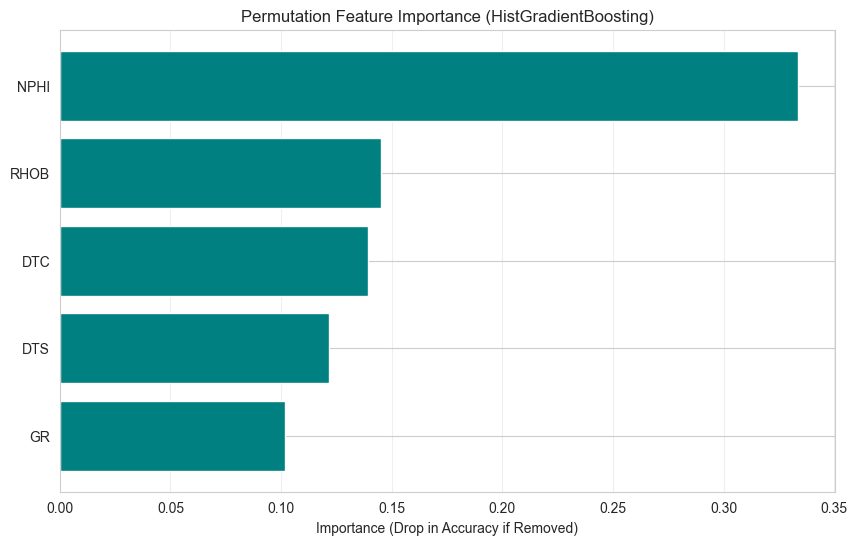

In [196]:
# 1. Get the exact feature names the model expects
# This attribute stores the names seen during .fit()
expected_features = model_gb.feature_names_in_
print(f"Model expects: {expected_features}")

# 2. Select EXACTLY those columns from your test dataframe
# This guarantees the names and order are perfect
X_test_safe = test_df[expected_features]

# 3. Run Permutation Importance on the Safe Data
print("Calculating Importance...")
result = permutation_importance(model_gb, X_test_safe, y_true_aligned, n_repeats=10, random_state=42)

# 4. Plot
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(expected_features[sorted_idx], result.importances_mean[sorted_idx], color='teal')
plt.title("Permutation Feature Importance (HistGradientBoosting)")
plt.xlabel("Importance (Drop in Accuracy if Removed)")
plt.grid(axis='x', alpha=0.3)
plt.show()